In [ ]:
#Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import networkx as nx

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.transforms import RandomLinkSplit
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric import seed_everything
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling
import torch.nn as nn


In [ ]:
RANDOM_STATE = 42
seed_everything(RANDOM_STATE)

In [ ]:
#ESTO ES PARA EJECUTAR EN COLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta donde guardaste el archivo gpickle
ruta_guardado = '/content/drive/My Drive/Colab Notebooks/GRAFO RETO/grafo.pkl'

# Carga el grafo desde el archivo gpickle
with open(ruta_guardado, 'rb') as file:
    G7 = pickle.load(file)

In [ ]:
#Numero de features
features=list(G7.nodes(data=True))[0][1]
print(features)
num_features = len(features['feature'])
print('Numero de atributos:',num_features)

{'feature': [7, 'B11730', 'warm', 1.1, 'Formal', 1, 'smooth', 'street', 'tight', 'freetime'], 'label': 0}
Numero de atributos: 10


In [ ]:
# Obtener nodos y características de nodos del grafo
nodos = list(G7.nodes)
conexion = list(G7.edges)
caracteristicas_nodos = [G7.nodes[nodo] for nodo in nodos]

In [ ]:
df_caracteristicas_nodos = pd.DataFrame(caracteristicas_nodos, index=nodos)
df_caracteristicas_nodos.head()

,feature,label
0,"[7, B11730, warm, 1.1, Formal, 1, smooth, stre...",0
1,"[7, ECE9D6, warm, 3.0, Informal, 2, horizontal...",1
2,"[7, 5F5E5E, warm, 2.0, Informal, 1, smooth, cl...",2
3,"[7, 00008b, warm, 2.0, Informal, 1, horizontal...",3
4,"[7, 000000, cold, 3.1, Informal, 3, sheets, ca...",4


In [ ]:
caracteristicas_df = df_caracteristicas_nodos['feature'].apply(pd.Series)
caracteristicas_df.columns = ['season','color','weather','subnivel','formalidad','adventurous','estampado','estilo','fit','application']
caracteristicas_df.head()

,season,color,weather,subnivel,formalidad,adventurous,estampado,estilo,fit,application
0,7,B11730,warm,1.1,Formal,1,smooth,street,tight,freetime
1,7,ECE9D6,warm,3.0,Informal,2,horizontal_stripes,classic,straight,work
2,7,5F5E5E,warm,2.0,Informal,1,smooth,classic,straight,freetime
3,7,00008b,warm,2.0,Informal,1,horizontal_stripes,casual,straight,freetime
4,7,000000,cold,3.1,Informal,3,sheets,casual,loose,freetime


In [ ]:
df_caracteristicas_nodos = pd.concat([df_caracteristicas_nodos.drop(columns=['feature']), caracteristicas_df], axis=1)
df_caracteristicas_nodos = df_caracteristicas_nodos.drop(columns=['season'])
df_caracteristicas_nodos.head()

,label,color,weather,subnivel,formalidad,adventurous,estampado,estilo,fit,application
0,0,B11730,warm,1.1,Formal,1,smooth,street,tight,freetime
1,1,ECE9D6,warm,3.0,Informal,2,horizontal_stripes,classic,straight,work
2,2,5F5E5E,warm,2.0,Informal,1,smooth,classic,straight,freetime
3,3,00008b,warm,2.0,Informal,1,horizontal_stripes,casual,straight,freetime
4,4,000000,cold,3.1,Informal,3,sheets,casual,loose,freetime


In [ ]:
df_caracteristicas_nodos.dtypes

,0
label,int64
color,object
weather,object
subnivel,float64
formalidad,object
adventurous,int64
estampado,object
estilo,object
fit,object
application,object


In [ ]:
df_caracteristicas_nodos = df_caracteristicas_nodos.astype(str)

In [ ]:
for col in df_caracteristicas_nodos.columns:
    print(f'{col}:{len(df_caracteristicas_nodos[col].unique())}')

label:1923
color:38
weather:2
subnivel:6
formalidad:2
adventurous:5
estampado:25
estilo:6
fit:5
application:5


In [ ]:
categoricas = df_caracteristicas_nodos.select_dtypes(exclude=['int']).columns
categoricas = categoricas[categoricas != 'label']
categoricas

Index(['color', 'weather', 'subnivel', 'formalidad', 'adventurous',
       'estampado', 'estilo', 'fit', 'application'],
      dtype='object')

In [ ]:
# Crear un LabelEncoder para cada columna categórica
df_codificado = pd.get_dummies(df_caracteristicas_nodos, columns=categoricas,drop_first=True)
df_codificado.head()
columnas = df_codificado.columns
df_codificado[columnas] = df_codificado[columnas].astype(int)
df_codificado.head()

,label,color_000081,color_00008b,color_0000FF,color_008000,color_153668,color_164A0A,color_40E0D0,color_462C0E,color_5C2F83,...,estilo_night,estilo_street,fit_nan,fit_oversize,fit_straight,fit_tight,application_night,application_special_occasion,application_work,application_working_girl
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_codificado.shape

(1923, 86)

In [ ]:
df_codificado.values

array([[   0,    0,    0, ...,    0,    0,    0],
       [   1,    0,    0, ...,    0,    1,    0],
       [   2,    0,    0, ...,    0,    0,    0],
       ...,
       [1920,    0,    0, ...,    0,    0,    0],
       [1921,    0,    0, ...,    0,    0,    0],
       [1922,    0,    1, ...,    0,    0,    0]])

In [ ]:
x_tensor = torch.tensor(df_codificado.drop(columns=['label']).values, dtype=torch.float32)
x_tensor.shape

torch.Size([1923, 85])

In [ ]:
x_tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [ ]:
edges=list(G7.edges)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
print(edge_index,edge_index.shape)

tensor([[   0,    0,    0,  ..., 1908, 1908, 1914],
        [  53,   68,   91,  ..., 1910, 1912, 1917]]) torch.Size([2, 150028])


In [ ]:
G7_data=Data(x=x_tensor, edge_index=edge_index)
G7_data

Data(x=[1923, 85], edge_index=[2, 150028])

In [ ]:
def receptive_field(G, node, k):
    """Calcula el receptive field de un nodo en k capas."""
    return set(nx.single_source_shortest_path_length(G, node, cutoff=k).keys())

def receptive_field_length_mean(G, max_k):
    """
    Calcula la media de la longitud del receptive field en el grafo para cada valor de k.

    Args:
        G: Grafo en formato NetworkX.
        max_k: Máximo número de capas (saltos) a considerar.

    Returns:
        dict: Media de la longitud del receptive field para cada k.
    """
    mean_lengths = {}

    for k in range(1, max_k + 1):
        lengths = []
        for node in G.nodes:
            # Obtener el receptive field usando BFS
            receptive_field = set(nx.single_source_shortest_path_length(G, node, cutoff=k).keys())
            lengths.append(len(receptive_field))

        # Calcular la media de las longitudes para el valor de k
        mean_lengths[k] = sum(lengths) / len(lengths)

    return mean_lengths

# Número máximo de capas a considerar
G = G7
max_k = 3
mean_lengths = receptive_field_length_mean(G, max_k)

# Imprimir los resultados
print("Media de longitudes del receptive field por número de capas:")
for k, mean_length in mean_lengths.items():
  print(f"- {k} capas: {mean_length:.2f} nodos")


Media de longitudes del receptive field por número de capas:
- 1 capas: 157.04 nodos
- 2 capas: 1642.93 nodos
- 3 capas: 1907.00 nodos


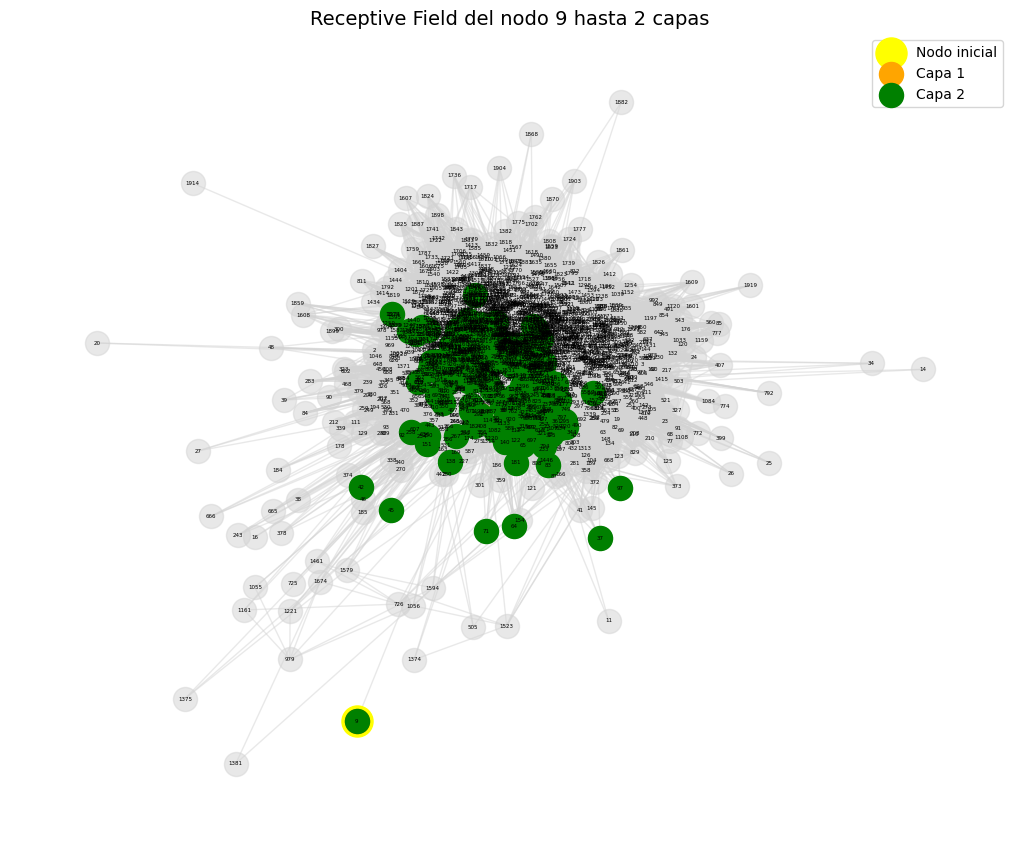

In [ ]:
def plot_receptive_field(G, node, max_k):
    """
    Grafica el receptive field de un nodo en un grafo para cada capa hasta max_k.

    Args:
        G (networkx.Graph): Grafo en el que se calculará y graficará el receptive field.
        node (int/str): Nodo inicial.
        max_k (int): Número máximo de capas a considerar.

    Returns:
        None
    """
    # Posiciones para los nodos en el grafo
    pos = nx.spring_layout(G)  # Distribución visual del grafo
    plt.figure(figsize=(10, 8))

    # Dibujar el grafo completo en gris como fondo
    nx.draw(G, pos, node_color="lightgray", edge_color="lightgray", with_labels=False, alpha=0.5)

    # Dibujar las etiquetas con un tamaño de fuente reducido
    labels = {n: str(n) for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=4)

    # Colores para las capas
    colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown']

    # Dibujar el nodo inicial
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='yellow', label="Nodo inicial", node_size=500)

    # Graficar los receptive fields capa por capa
    for k in range(1, max_k + 1):
        # Calcular los nodos alcanzables en la capa k
        nodes_in_layer = receptive_field(G, node, k)

        # Dibujar los nodos alcanzables en esta capa
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=nodes_in_layer,
            node_color=colors[k % len(colors)],
            label=f'Capa {k}',
            node_size=300
        )

    # Agregar título y leyenda
    plt.title(f"Receptive Field del nodo {node} hasta {max_k} capas", fontsize=14)
    plt.legend(scatterpoints=1)
    plt.show()

# Ejemplo de uso
if __name__ == "__main__":
    # Crear un grafo de ejemplo
    G = G7

    # Nodo inicial y número máximo de capas
    start_node = 9
    max_k = 2

    # Graficar el receptive field del nodo inicial
    plot_receptive_field(G, start_node, max_k)


In [ ]:
# Realizar el split de datos fuera del bucle
split = RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
    edge_types=[0]
)
train_data, val_data, test_data = split(G7_data)

In [ ]:
print('train_data: ', train_data)
print('val_data: ', val_data)
print('test_data: ', test_data)

train_data:  Data(x=[1923, 85], edge_index=[2, 255050], edge_label=[127525], edge_label_index=[2, 127525])
val_data:  Data(x=[1923, 85], edge_index=[2, 255050], edge_label=[15002], edge_label_index=[2, 15002])
test_data:  Data(x=[1923, 85], edge_index=[2, 270052], edge_label=[30004], edge_label_index=[2, 30004])


## GNN con mejoras

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, use_skip=True):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()

        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Decodificar todos los posibles enlaces
        adjacency_scores = z @ z.T
        return adjacency_scores

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, use_skip=True):
        super().__init__()

        # Capas de preprocesamiento (MLP Layers)
        self.pre_mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU()
        )

        # Capas GNN principales
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.3)

        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)

        # Capas de postprocesamiento (MLP Layers)
        self.post_mlp = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )

    def encode(self, x, edge_index):
        # Preprocesamiento
        x = self.pre_mlp(x)

        # Primera capa con Batch Normalization
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = self.dropout(x)

        # Segunda capa con Batch Normalization
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()

        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Decodificar todos los posibles enlaces
        adjacency_scores = z @ z.T
        return adjacency_scores

    def forward(self, x, edge_index):
        # Encode and post-process
        z = self.encode(x, edge_index)
        z = self.post_mlp(z)
        return z


MODELO GAT


In [ ]:
import torch
from torch_geometric.nn import GATConv

class GatNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, use_skip=True, heads=1):
        super().__init__()
        # Primera capa GAT
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=False)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)  # Batch Normalization
        self.dropout = torch.nn.Dropout(p=0.3)  # Regularización con dropout

        # Segunda capa GAT
        self.gat2 = GATConv(hidden_channels, out_channels, heads=heads, concat=False)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)  # Batch Normalization

        self.use_skip = use_skip  # Bandera para habilitar skip connections

    def encode(self, x, edge_index):
        x_initial = x  # Guardar la entrada inicial para conexión residual

        # Primera capa GAT
        x = self.gat1(x, edge_index)
        x = self.bn1(x)  # Batch Normalization
        x = self.dropout(x)  # Dropout
        x = x.relu()  # ReLU después de Dropout

        # Segunda capa GAT
        x = self.gat2(x, edge_index)
        x = self.bn2(x)  # Batch Normalization

        # Conexión residual (opcional)
        if self.use_skip:
            x = x + x_initial

        return x

    def decode(self, z, edge_label_index):
        # Normalización de embeddings y producto escalar
        z = torch.nn.functional.normalize(z, p=2, dim=-1)
        edge_embeddings = (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
        return edge_embeddings

    def decode_all(self, z):
        # Decodificar todos los posibles enlaces
        adjacency_scores = z @ z.T
        return adjacency_scores

    def reset_parameters(self):
        self.gat1.reset_parameters()
        self.bn1.reset_parameters()
        self.gat2.reset_parameters()
        self.bn2.reset_parameters()


MODELO GRAPHSAGE

In [ ]:
import torch
from torch_geometric.nn import SAGEConv

class SageNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, use_skip=True):
        super().__init__()
        # Primera capa GraphSAGE
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)  # Batch Normalization
        self.dropout = torch.nn.Dropout(p=0.3)  # Regularización con dropout

        # Segunda capa GraphSAGE
        self.sage2 = SAGEConv(hidden_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)  # Batch Normalization

        self.use_skip = use_skip  # Bandera para habilitar skip connections

    def encode(self, x, edge_index):
        x_initial = x  # Guardar la entrada inicial para conexión residual

        # Primera capa GraphSAGE
        x = self.sage1(x, edge_index)
        x = self.bn1(x)  # Batch Normalization
        x = self.dropout(x)  # Dropout
        x = x.relu()  # ReLU después de Dropout

        # Segunda capa GraphSAGE
        x = self.sage2(x, edge_index)
        x = self.bn2(x)  # Batch Normalization

        # Conexión residual (opcional)
        if self.use_skip:
            x = x + x_initial

        return x

    def decode(self, z, edge_label_index):
        # Normalización de embeddings y producto escalar
        z = torch.nn.functional.normalize(z, p=2, dim=-1)
        edge_embeddings = (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
        return edge_embeddings

    def decode_all(self, z):
        # Decodificar todos los posibles enlaces
        adjacency_scores = z @ z.T
        return adjacency_scores

    def reset_parameters(self):
        self.sage1.reset_parameters()
        self.bn1.reset_parameters()
        self.sage2.reset_parameters()
        self.bn2.reset_parameters()





Funcion entrenamiento

In [ ]:
def train_link_predictor(model, train_data, val_data, optimizer, criterion, n_epochs=200):

    best_val_auc = 0.0
    epochs_without_improvement = 0
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()

        # Obtener representaciones latentes de nodos
        z = model.encode(train_data.x, train_data.edge_index)

        # Muestreo de negativos dinámicos en cada época
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        # Concatenar positivos y negativos para entrenamiento
        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        # Predicción y cálculo de pérdida
        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")


        #if epochs_without_improvement >= patience:
         #   print(f"Early stopping at epoch {epoch} as there is no improvement in validation AUC.")
          #  break

    return model


@torch.no_grad()
def eval_link_predictor(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


In [ ]:
model = Net(G7_data.num_features, 64, 32)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
model = train_link_predictor(model, train_data, val_data, optimizer, criterion)

test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: 0.757, Val AUC: 0.764
Epoch: 020, Train Loss: 0.682, Val AUC: 0.761
Epoch: 030, Train Loss: 0.672, Val AUC: 0.746
Epoch: 040, Train Loss: 0.653, Val AUC: 0.722
Epoch: 050, Train Loss: 0.654, Val AUC: 0.773
Epoch: 060, Train Loss: 0.643, Val AUC: 0.802
Epoch: 070, Train Loss: 0.632, Val AUC: 0.800
Epoch: 080, Train Loss: 0.633, Val AUC: 0.800
Epoch: 090, Train Loss: 0.653, Val AUC: 0.812
Epoch: 100, Train Loss: 0.635, Val AUC: 0.808
Epoch: 110, Train Loss: 0.618, Val AUC: 0.815
Epoch: 120, Train Loss: 0.615, Val AUC: 0.804
Epoch: 130, Train Loss: 0.612, Val AUC: 0.791
Epoch: 140, Train Loss: 0.612, Val AUC: 0.814
Epoch: 150, Train Loss: 0.607, Val AUC: 0.819
Epoch: 160, Train Loss: 0.608, Val AUC: 0.802
Epoch: 170, Train Loss: 0.605, Val AUC: 0.821
Epoch: 180, Train Loss: 0.602, Val AUC: 0.811
Epoch: 190, Train Loss: 0.604, Val AUC: 0.835
Epoch: 200, Train Loss: 0.602, Val AUC: 0.829
Test: 0.829


PRUEBA DIFERENTES HIPERPARAMETROS

In [ ]:
def hyperparameter_search(train_data, val_data, num_features):
    results = []  # Para almacenar los resultados de cada combinación

    learning_rates = [0.1, 0.01, 0.001]
    layers = [(64,32),(128,64)]

    for layer in layers:
      for lr in learning_rates:
        print('Layers:', layer, 'Learning Rate:', lr)
        model = Net(G7_data.num_features, hidden_channels = layer[0], out_channels = layer[1])
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Entrenamiento del modelo
        model = train_link_predictor(model, train_data, val_data, optimizer, criterion)

        # Evaluación del modelo en el conjunto de prueba
        val_auc = eval_link_predictor(model, val_data)

        # Registrar los resultados
        result = {'Layers': layer, 'Learning Rate': lr, 'Val AUC': val_auc}
        results.append(result)

        # Ordenar resultados por AUC de validación
        results = sorted(results, key=lambda x: x['Val AUC'], reverse=True)

        # Mostrar la mejor combinación
        best_result = results[0]
        print(f"Best combination: lr={best_result['Learning Rate']}, layers={best_result['Layers']} with val_auc={best_result['Val AUC']}")

    return results

hyperparameter_search(train_data, val_data, G7_data.num_features)


Layers: (64, 32) Learning Rate: 0.1
Epoch: 010, Train Loss: 0.906, Val AUC: 0.774
Epoch: 020, Train Loss: 0.693, Val AUC: 0.500
Epoch: 030, Train Loss: 0.693, Val AUC: 0.500
Epoch: 040, Train Loss: 0.693, Val AUC: 0.500
Epoch: 050, Train Loss: 0.693, Val AUC: 0.500
Epoch: 060, Train Loss: 0.693, Val AUC: 0.500
Epoch: 070, Train Loss: 0.693, Val AUC: 0.500
Epoch: 080, Train Loss: 0.693, Val AUC: 0.500
Epoch: 090, Train Loss: 0.693, Val AUC: 0.500
Epoch: 100, Train Loss: 0.693, Val AUC: 0.500
Epoch: 110, Train Loss: 0.693, Val AUC: 0.500
Epoch: 120, Train Loss: 0.693, Val AUC: 0.500
Epoch: 130, Train Loss: 0.693, Val AUC: 0.500
Epoch: 140, Train Loss: 0.693, Val AUC: 0.500
Epoch: 150, Train Loss: 0.693, Val AUC: 0.500
Epoch: 160, Train Loss: 0.693, Val AUC: 0.500
Epoch: 170, Train Loss: 0.693, Val AUC: 0.500
Epoch: 180, Train Loss: 0.693, Val AUC: 0.500
Epoch: 190, Train Loss: 0.693, Val AUC: 0.500
Epoch: 200, Train Loss: 0.693, Val AUC: 0.500
Best combination: lr=0.1, layers=(64, 32) wi

KeyboardInterrupt: 

In [ ]:
embeddings = model.encode(train_data.x, train_data.edge_index)
embeddings

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2226, 0.0000,  ..., 0.0000, 1.1192, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3901, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4563, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

OPTIMIZACION GAT

Best combination: lr=0.01, hidden_channels=128, out_channels=64 with val_auc=0.8186284400848051

In [ ]:
import torch
from itertools import product
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

# Lista de combinaciones de capas
layers = [(64, 32), (128, 64)]
learning_rates = [0.1, 0.01, 0.001]  # Lista de tasas de aprendizaje a probar

# Función para probar diferentes combinaciones de hiperparámetros
def hyperparameter_search(train_data, val_data, num_features):
    results = []  # Para almacenar los resultados de cada combinación

    # Iterar sobre todas las combinaciones de tasas de aprendizaje y capas
    for lr, (hidden_channels, out_channels) in product(learning_rates, layers):
        print(f"Testing combination: lr={lr}, hidden_channels={hidden_channels}, out_channels={out_channels}")

        # Crear modelo con los hiperparámetros actuales
        model = GatNet(num_features, hidden_channels, out_channels, use_skip = False)

        # Configurar el optimizador y la función de pérdida
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Entrenar el modelo
        trained_model = train_link_predictor(model, train_data, val_data, optimizer, criterion)

        # Evaluar el modelo
        val_auc = eval_link_predictor(trained_model, val_data)

        # Almacenar los resultados
        results.append({
            'lr': lr,
            'hidden_channels': hidden_channels,
            'out_channels': out_channels,
            'val_auc': val_auc
        })

    # Ordenar resultados por AUC de validación
    results = sorted(results, key=lambda x: x['val_auc'], reverse=True)

    # Mostrar la mejor combinación
    best_result = results[0]
    print(f"Best combination: lr={best_result['lr']}, hidden_channels={best_result['hidden_channels']}, out_channels={best_result['out_channels']} with val_auc={best_result['val_auc']}")

    return results

# Ejemplo de uso:
results = hyperparameter_search(train_data, val_data, G7_data.num_features)


Testing combination: lr=0.1, hidden_channels=64, out_channels=32
Epoch: 010, Train Loss: 0.679, Val AUC: 0.567
Epoch: 020, Train Loss: 0.663, Val AUC: 0.652
Epoch: 030, Train Loss: 0.670, Val AUC: 0.600
Epoch: 040, Train Loss: 0.668, Val AUC: 0.487
Epoch: 050, Train Loss: 0.672, Val AUC: 0.570
Epoch: 060, Train Loss: 0.675, Val AUC: 0.607
Epoch: 070, Train Loss: 0.669, Val AUC: 0.607
Epoch: 080, Train Loss: 0.668, Val AUC: 0.630
Epoch: 090, Train Loss: 0.666, Val AUC: 0.654
Epoch: 100, Train Loss: 0.673, Val AUC: 0.405
Epoch: 110, Train Loss: 0.664, Val AUC: 0.481
Epoch: 120, Train Loss: 0.666, Val AUC: 0.481
Epoch: 130, Train Loss: 0.674, Val AUC: 0.509
Epoch: 140, Train Loss: 0.665, Val AUC: 0.555
Epoch: 150, Train Loss: 0.664, Val AUC: 0.552
Epoch: 160, Train Loss: 0.663, Val AUC: 0.540
Epoch: 170, Train Loss: 0.668, Val AUC: 0.469
Epoch: 180, Train Loss: 0.667, Val AUC: 0.506
Epoch: 190, Train Loss: 0.661, Val AUC: 0.512
Epoch: 200, Train Loss: 0.666, Val AUC: 0.436
Testing combina

OPTIMIZACION SAGE

Best combination: lr=0.01, hidden_channels=128, out_channels=64 with val_auc=0.826980674895927

In [ ]:
import torch
from itertools import product
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

# Lista de combinaciones de capas
layers = [(64, 32), (128, 64)]
learning_rates = [0.1, 0.01, 0.001]  # Lista de tasas de aprendizaje a probar

# Función para probar diferentes combinaciones de hiperparámetros
def hyperparameter_search(train_data, val_data, num_features):
    results = []  # Para almacenar los resultados de cada combinación

    # Iterar sobre todas las combinaciones de tasas de aprendizaje y capas
    for lr, (hidden_channels, out_channels) in product(learning_rates, layers):
        print(f"Testing combination: lr={lr}, hidden_channels={hidden_channels}, out_channels={out_channels}")

        # Crear modelo con los hiperparámetros actuales
        model = SageNet(num_features, hidden_channels, out_channels, use_skip = False)

        # Configurar el optimizador y la función de pérdida
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Entrenar el modelo
        trained_model = train_link_predictor(model, train_data, val_data, optimizer, criterion)

        # Evaluar el modelo
        val_auc = eval_link_predictor(trained_model, val_data)

        # Almacenar los resultados
        results.append({
            'lr': lr,
            'hidden_channels': hidden_channels,
            'out_channels': out_channels,
            'val_auc': val_auc
        })

    # Ordenar resultados por AUC de validación
    results = sorted(results, key=lambda x: x['val_auc'], reverse=True)

    # Mostrar la mejor combinación
    best_result = results[0]
    print(f"Best combination: lr={best_result['lr']}, hidden_channels={best_result['hidden_channels']}, out_channels={best_result['out_channels']} with val_auc={best_result['val_auc']}")

    return results

# Ejemplo de uso:
results_sage = hyperparameter_search(train_data, val_data, G7_data.num_features)


Testing combination: lr=0.1, hidden_channels=64, out_channels=32
Epoch: 010, Train Loss: 0.619, Val AUC: 0.645
Epoch: 020, Train Loss: 0.610, Val AUC: 0.630
Epoch: 030, Train Loss: 0.606, Val AUC: 0.656
Epoch: 040, Train Loss: 0.603, Val AUC: 0.717
Epoch: 050, Train Loss: 0.601, Val AUC: 0.777
Epoch: 060, Train Loss: 0.599, Val AUC: 0.798
Epoch: 070, Train Loss: 0.598, Val AUC: 0.804
Epoch: 080, Train Loss: 0.597, Val AUC: 0.813
Epoch: 090, Train Loss: 0.596, Val AUC: 0.813
Epoch: 100, Train Loss: 0.595, Val AUC: 0.817
Epoch: 110, Train Loss: 0.595, Val AUC: 0.815
Epoch: 120, Train Loss: 0.595, Val AUC: 0.814
Epoch: 130, Train Loss: 0.594, Val AUC: 0.820
Epoch: 140, Train Loss: 0.594, Val AUC: 0.810
Epoch: 150, Train Loss: 0.594, Val AUC: 0.817
Epoch: 160, Train Loss: 0.594, Val AUC: 0.812
Epoch: 170, Train Loss: 0.594, Val AUC: 0.814
Epoch: 180, Train Loss: 0.593, Val AUC: 0.811
Epoch: 190, Train Loss: 0.594, Val AUC: 0.814
Epoch: 200, Train Loss: 0.593, Val AUC: 0.823
Testing combina




### Crear nueva prenda

In [ ]:
test_data.edge_label_index[0][0].item()

691

In [ ]:
test_data.edge_label_index[0][0].item()

691

In [ ]:
df_caracteristicas_nodos.iloc[test_data.edge_label_index[0][0].item()]

,691
label,691
color,DFC8B2
weather,warm
subnivel,1.1
formalidad,Formal
adventurous,1
estampado,vertical_stripes
estilo,minimal
fit,loose
application,freetime
